# Section 12. Convolutional Neural Network을 이용한 MNIST Classification
 - 임경태

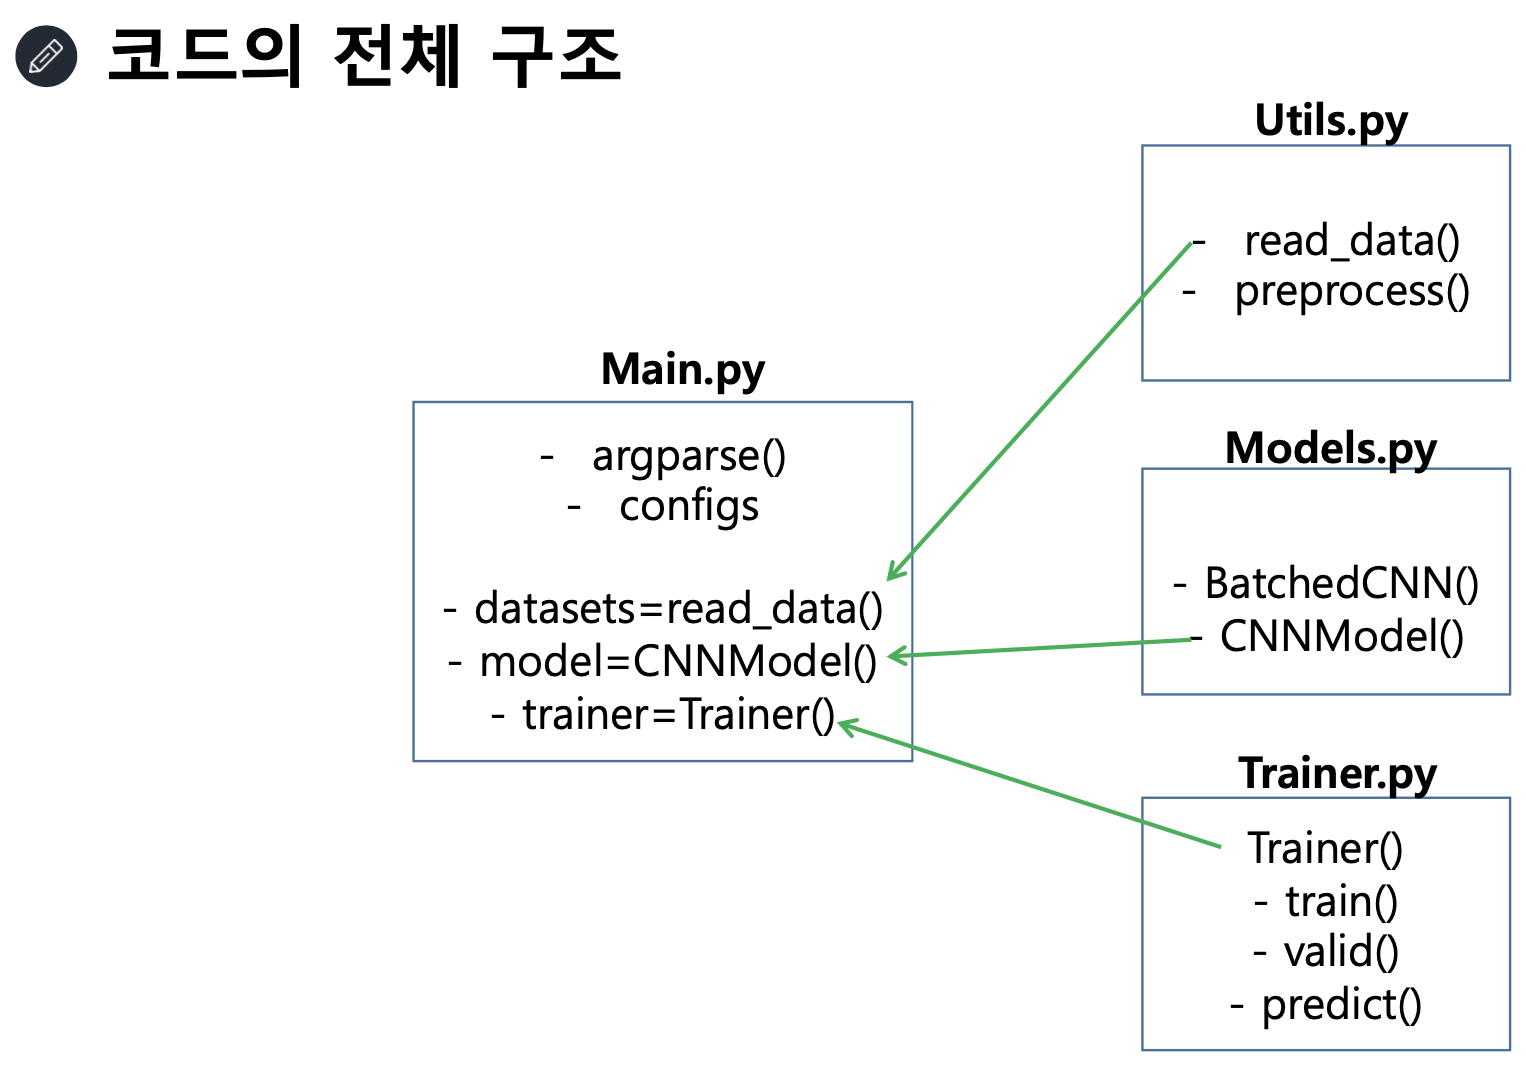

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn

## 01. Utils.py

In [ ]:
from torchvision import datasets, transforms

def read_data(is_train=True):

  dataset = datasets.MNIST('../MNIST', train=True, download=True)

  return dataset


## 02. Model.py

In [ ]:
class BatchedCNNLayer_Norm(nn.Module):

  def __init__(self, input_channel, output_channel):
    self.input_channel = input_channel
    self.output_channel = output_channel
    super().__init__()

    self.layer = nn.Sequential(
        nn.Conv2d(self.input_channel, self.output_channel, kernel_size=(3,3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(self.output_channel),
        nn.Conv2d(self.output_channel, self.output_channel, kernel_size=(3,3), padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(self.output_channel),
        nn.Conv2d(self.output_channel, self.output_channel, kernel_size=(3,3), stride=2, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(self.output_channel),
    )

  def forward(self, input_data):
    return self.layer(input_data)

class BatchedCNNLayer(nn.Module):

  def __init__(self, input_channel, output_channel):
    self.input_channel = input_channel
    self.output_channel = output_channel
    super().__init__()

    self.layer = nn.Sequential(
        nn.Conv2d(self.input_channel, self.output_channel, kernel_size=(3,3), padding=1),
        nn.ReLU(),
        nn.Conv2d(self.output_channel, self.output_channel, kernel_size=(3,3), stride=2, padding=1),
        nn.ReLU()
    )

  def forward(self, input_data):
    return self.layer(input_data)


class CNNModel(nn.Module):

  def __init__(self, num_classes):
    self.num_classes = num_classes
    super().__init__()


    self.cnn_encoder = nn.Sequential(
        BatchedCNNLayer(1, 32),
        BatchedCNNLayer(32, 64),
        BatchedCNNLayer(64, 128),
        BatchedCNNLayer(128, 256),
        BatchedCNNLayer(256, 512),
    )

    self.classifier = nn.Sequential(
        nn.Linear(512, 200),
        nn.ReLU(),
        nn.Linear(200, self.num_classes)  
    )

  
  def forward(self, input_data):
    #print("Here is the size of input data: ", input_data.size())
    input_tensor = input_data.view(1, 1, input_data.size(-1), -1)
    encoder_out = self.cnn_encoder( input_tensor )
    logits = self.classifier(encoder_out.view(-1, 512))

    return logits



## 03. Trainer.py

In [ ]:
class Trainer():
  def __init__(self, model, optimizer, loss_function):
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function

    super().__init__()

  def train(self, x, y, config):
    self.model.train()
    total_loss = []
    total_predicted = []

    for idx in range(len(x)):
      self.optimizer.zero_grad()

      logits = self.model(x[idx])
      loss = self.loss_function(logits, y[idx].unsqueeze(0))
      total_loss.append(loss.item())
      predicted = logits.argmax()
      total_predicted.append(predicted.item())
            
      if config.verbose % (idx+1) == 0:
        print(sum(total_loss)/len(total_loss))

      loss.backward()
      self.optimizer.step()

    accuracy = (sum(np.array(total_predicted) == np.array(y.cpu()))) / len(y)

    return total_loss, accuracy

  def valid(self, x, y, config):
    self.model.eval()
    total_loss = []
    total_predicted = []

    with torch.no_grad():
      for idx in range(len(x)):
        logits = self.model(x[idx])
        predicted = logits.argmax(dim=1)
        loss = self.loss_function(logits, y[idx].unsqueeze(0))

        total_loss.append(loss.item())
        total_predicted.append(predicted.item())

    accuracy = (sum(np.array(total_predicted) == np.array(y.cpu()))) / len(y)

    return total_loss, accuracy


  def test(self, x, config):
    return 0


## 04. Main.py
 -  python Main.py --model_name="base" --gpu_num="1,2,3" --batch_size="32"


In [ ]:
import argparse
from argparse import Namespace
import easydict

def get_argparser(is_jupyter=True):

  if (is_jupyter): #When the code is working on Jupyter notebook
    args = easydict.EasyDict({
        'model_name': 'base',
        'gpu_num': 0 if torch.cuda.is_available() else -1,
        'batch_size': 16,
        'epoch_size': 50,
        'out_encoder_size': 2,
        'verbose': 100 })
  else:
    parser = argparse.ArgumentParser()
    parser.add_argument('--model_name', required=True, default='base')
    parser.add_argument('--gpu_num', type=int, default=0 if torch.cuda.is_available() else -1)
    parser.add_argument('--batch_size', type=int, default=16)
    parser.add_argument('--epoch_size', type=int, default=50)
    parser.add_argument('--out_encoder_size', type=int, default=2)
    parser.add_argument('--verbose', type=int, default=1)
    args = parser.parse_args()

  return args

config = get_argparser()  
device = torch.device('cpu') if config.gpu_num < 0 else torch.device('cuda:'+str(config.gpu_num))
print("GPU: ", device, " are used")
datasets = read_data(is_train=True)

GPU:  cuda:0  are used


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../MNIST/MNIST/raw



In [ ]:
model = CNNModel(num_classes=10).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lr=0.001, params=model.parameters())
trainer = Trainer(model, optimizer, loss_function)


In [ ]:
lowewst_loss = 100000
best_model = None

for idx in range(config.epoch_size):
  train_losses, train_accuracy = trainer.train(datasets.data[:1000].float().to(device), datasets.targets[:1000].to(device), config)
  train_loss_sum = sum(train_losses)/len(datasets.data)
  valid_losses, valid_accuracy = trainer.valid(datasets.data[:100].float().to(device), datasets.targets[:100].to(device), config)
  valid_loss_sum = sum(valid_losses)/len(datasets.data)

  print("EPOCH", idx, ":  TRAIN LOSS=" , train_loss_sum, " VALID LOSS=", valid_loss_sum, " VALID_ACCURACY=" ,valid_accuracy )
  '''
  if valid_loss_sum <= lowewst_loss:
    lowewst_loss = valid_loss_sum
    torch.save({
        'model': model.state_dict(),
        'config': config
    }, config.model_name+"_EPOCH_"+str(idx)+"_LOSS_"+str(valid_loss_sum))#,str(idx),"_LOSS_",sum_loss)
  '''


2.317566156387329
2.336875557899475
2.32059383392334
2.3099668979644776
2.30913245677948
2.3152233481407167
2.307973747253418
2.310477714538574
2.308369221687317
EPOCH 0 :  TRAIN LOSS= 0.03844020507335663  VALID LOSS= 0.003909291448195775  VALID_ACCURACY= 0.14
3.007066249847412
2.6460039615631104
2.4505931735038757
2.4268688201904296
2.355125975608826
2.337111234664917
2.323112058639526
2.326241340637207
2.311991789340973
EPOCH 1 :  TRAIN LOSS= 0.03896335050950875  VALID LOSS= 0.0038245606621106465  VALID_ACCURACY= 0.1
2.386173963546753
2.3283385038375854
2.281129240989685
2.297096061706543
2.2891807079315187
2.306702971458435
2.2984769535064697
2.3072545099258424
2.299980778694153
EPOCH 2 :  TRAIN LOSS= 0.03846531446287409  VALID LOSS= 0.0037969176590442657  VALID_ACCURACY= 0.14
2.3466200828552246
2.2965939044952393
2.2495811581611633
2.2707221508026123
2.38840970993042
2.3425886273384093
2.321828632354736
2.3294163298606874
2.254949615597725
EPOCH 3 :  TRAIN LOSS= 0.03503101591336084

KeyboardInterrupt: ignored